In [1]:
import numpy as np
import pandas as pd
import dowhy
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',35)
import sys
sys.path.append("../scripts/")
#from plot import plot_distribution
import warnings
warnings.filterwarnings('ignore')
from dowhy import CausalModel
from IPython.display import Image, display

In [2]:
df = pd.read_csv("../data/processed_data.csv")
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


* Feature selection - logistic regression

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=20, test_size=0.2)

#X = train.drop(['diagnosis'],axis=1)
#y = df.diagnosis.values

print('Train: ', train.shape)
print('Hold-out: ', test.shape)

Train:  (455, 31)
Hold-out:  (114, 31)


In [4]:
causal_graph = """
digraph{
radius_mean;
texture_mean;
perimeter_mean;
area_mean;
smoothness_mean;
concavity_mean;
concave points_mean;
radius_se;
perimeter_se;
area_se;
smoothness_se;
concave points_se;
radius_worst;
texture_worst;
perimeter_worst;
area_worst;
smoothness_worst;
concavity_worst;
concave points_worst;
symmetry_worst;
fractal_dimension_worst;
U[label="Unobserved Confounders"];
radius_mean -> perimeter_mean;radius_mean -> area_mean;radius_mean -> smoothness_mean;radius_mean->high_radius;
concave_points_mean->concavity_mean;radius_se -> perimeter_se;radius_se -> area_se;radius_se -> smoothness_se;
radius_worst -> perimeter_worst;radius_worst -> area_worst;radius_worst -> smoothness_worst;concave points_worst->concavity_worst;
radius_se -> perimeter_se;radius_se -> area_se;radius_se -> smoothness_se;radius_worst -> perimeter_worst;
radius_worst -> area_worst;radius_worst -> smoothness_worst;concave points_worst->concavity_worst;

U->perimeter_mean;U->area_mean;U->smoothness_mean;U->texture_mean;U->concavity_mean;U->perimeter_se;U->area_se;U->smoothness_se;
U->smoothness_se;U->concave points_se;U->perimeter_worst;U->area_worst;U->smoothness_worst;U->texture_worst;U->concavity_worst;
U->symmetry_worst;U->fractal_dimension_worst;U->high_radius;U->diagnosis;

texture_mean->diagnosis;perimeter_mean->diagnosis;area_mean->diagnosis;smoothness_mean->diagnosis;concavity_mean->diagnosis;
perimeter_se->diagnosis;area_se->diagnosis;smoothness_se->diagnosis;concave points_se->diagnosis;high_radius->diagnosis;
texture_worst->diagnosis;perimeter_worst->diagnosis;area_worst->diagnosis;smoothness_worst->diagnosis;
concavity_worst->diagnosis;concave points_worst->diagnosis;symmetry_worst->diagnosis;fractal_dimension_worst->diagnosis;
}
"""

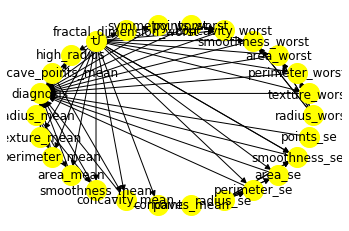

In [5]:
# Create a causal model from the train data.
model= CausalModel(
        data = train,
        graph=causal_graph.replace("\n", " "),
        treatment='radius_mean',
        outcome='diagnosis')
model.view_model()

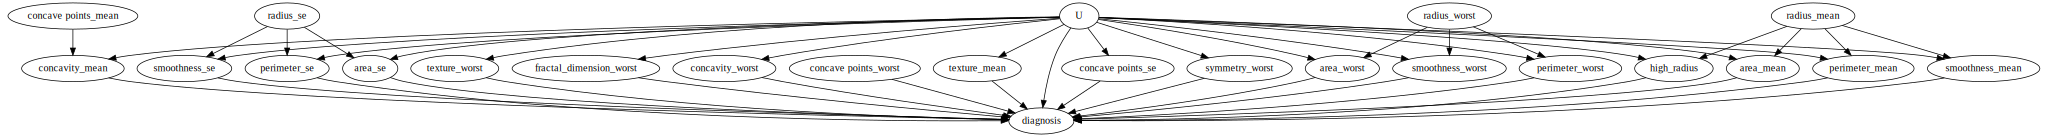

In [6]:
#area and perimeter functions of radius
from causalgraphicalmodels import CausalGraphicalModel
causal = CausalGraphicalModel(
    nodes=['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'concavity_mean', 'concave points_mean', 'radius_se',
       'perimeter_se', 'area_se', 'smoothness_se', 'concave points_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'diagnosis',
       'high_radius','U'],
    edges=[
        ("radius_mean", "perimeter_mean"), 
        ("radius_mean", "area_mean"),
        ("radius_mean","smoothness_mean"),
        ("concave points_mean","concavity_mean"),
        ("radius_mean","high_radius"),
        ("radius_se", "perimeter_se"), 
        ("radius_se", "area_se"),
        ("radius_se","smoothness_se"),
        ("radius_worst", "perimeter_worst"), 
        ("radius_worst", "area_worst"),
        ("radius_worst","smoothness_worst"),
        ("concave points_worst","concavity worst"),
        ("U","perimeter_mean"),
        ("U","area_mean"),
        ("U","texture_mean"),
        ("U","smoothness_mean"),
        ("U","concavity_mean"),
        ("U","perimeter_se"),
        ("U","area_se"),
        ("U","concave points_se"),
        ("U","smoothness_se"),
        ("U","perimeter_worst"),
        ("U","area_worst"),
        ("U","texture_worst"),
        ("U","smoothness_worst"),
        ("U","concavity_worst"),
        ("U","symmetry_worst"),
        ("U","fractal_dimension_worst"),
        ("U","high_radius"),
        ("U","diagnosis"),
        ("high_radius","diagnosis"),
        ("perimeter_mean","diagnosis"),
        ("area_mean","diagnosis"),
        ("texture_mean","diagnosis"),
        ("smoothness_mean","diagnosis"),
        ("concavity_mean","diagnosis"),
        ("smoothness_mean","diagnosis"),
        ("concavity_mean","diagnosis"),
        ("perimeter_se","diagnosis"),
        ("area_se","diagnosis"),
        ("smoothness_se","diagnosis"),
        ("concavity_se","diagnosis"),
        ("smoothness_se","diagnosis"),
        ("concave points_se","diagnosis"),
        ("concave points_worst","diagnosis"),
        ("perimeter_worst","diagnosis"),
        ("area_worst","diagnosis"),
        ("texture_worst","diagnosis"),
        ("smoothness_worst","diagnosis"),
        ("concavity_worst","diagnosis"),
        ("smoothness_worst","diagnosis"),
        ("symmetry_worst","diagnosis"),
        ("fractal_dimension_worst","diagnosis")
    ]
)
# draw return a graphviz `dot` object, which jupyter can render
causal.draw()

The ground truth graph

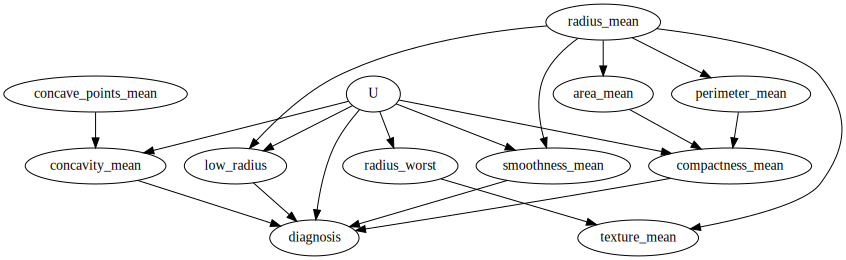

In [7]:
from causalgraphicalmodels import CausalGraphicalModel
causal2 = CausalGraphicalModel(
    nodes=['radius_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean',
           'concave_points_mean','diagnosis','low_radius','texture_mean','radius_worst','U'],
    edges=[
        ("radius_mean", "perimeter_mean"), 
        ("radius_mean", "area_mean"),
        ("radius_mean", "texture_mean"),
        ("radius_mean","smoothness_mean"),
        ("radius_mean","low_radius"),
         ("radius_worst", "texture_mean"),
        ("area_mean","compactness_mean"),
        ("perimeter_mean","compactness_mean"),
        ("concave_points_mean","concavity_mean"),
        ("U","compactness_mean"),
        ("U","smoothness_mean"),
        ("U","concavity_mean"),
         ("U","radius_worst"),
        ("U","low_radius"),
        ("U","diagnosis"),
        ("low_radius","diagnosis"),
        ("smoothness_mean","diagnosis"),
        ("concavity_mean","diagnosis"),
        ("compactness_mean","diagnosis")
    ]
)
causal2.draw()

In [8]:
# Identify the Causal Effect
estimands = model.identify_effect()
print(estimands)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(diagnosis|texture_mean,area_se,texture_worst,smoothn
d[radiusₘₑₐₙ]                                                                 

                                                                              
ess_se,smoothness_worst,fractal_dimension_worst,concavity_mean,perimeter_se,co
                                                                              

                                                                              
ncavity_worst,radius_se,radius_worst,perimeter_worst,area_worst,symmetry_worst
                                                                              

  
))
  
Estimand assumption 1, Unconfoundedness: If U→{radius_mean} and U→diagnosis then P(diagnosis|radius_mean,texture_mean,area_se,texture_worst,smoothness_se,smoothness_worst,fractal_di

In [9]:
#Causal Effect Estimation
#Method based on estimating the treatment assignment
estimate = model.estimate_effect(estimands,method_name = "backdoor.propensity_score_weighting")
print(estimate)

KeyError: "['U', 'points_se', 'points_worst', 'concave_points_mean'] not in index"

In [ ]:
stop

In [ ]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)

print("Causal Estimate is " + str(estimate.value))
data_1 = train_df[train_df["diagnosis"]==1]
data_0 = train_df[train_df["diagnosis"]==0]

print("ATE", np.mean(data_1["radius_mean"])- np.mean(data_0["radius_mean"]))

In [ ]:
log = LogisticRegression()
log.fit(X,y)
feature_importance = log.coef_[0]
#for i,v in enumerate(feature_importance):
   # print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#plt.bar([x for x in range(len(feature_importance))], feature_importance)

In [ ]:
features = pd.DataFrame()
features['attributes'] = X.columns.to_list()
features['score'] = log.coef_[0]
features.head()